In [49]:
# REAL DATA EXPERIMENTS
# RUN WITH python run_real_experiments_dfNGP.py
#               _                 _   _      
#              | |               | | (_)     
#    __ _ _ __ | |_ __ _ _ __ ___| |_ _  ___ 
#   / _` | '_ \| __/ _` | '__/ __| __| |/ __|
#  | (_| | | | | || (_| | | | (__| |_| | (__ 
#   \__,_|_| |_|\__\__,_|_|  \___|\__|_|\___|
# 
model_name = "dfNGP"

# import configs to we can access the hypers with getattr
import configs
from configs import PATIENCE, MAX_NUM_EPOCHS, NUM_RUNS, WEIGHT_DECAY

# Reiterating import for visibility
MAX_NUM_EPOCHS = MAX_NUM_EPOCHS
NUM_RUNS = NUM_RUNS
WEIGHT_DECAY = WEIGHT_DECAY
PATIENCE = PATIENCE

# TODO: Delete overwrite, run full
NUM_RUNS = 1
# TODO:
SCALE_NOISE = 10
PATIENCE = 2000

# assign model-specific variable
MODEL_LEARNING_RATE = getattr(configs, f"{model_name}_REAL_LEARNING_RATE")
MODEL_REAL_RESULTS_DIR = getattr(configs, f"{model_name}_REAL_RESULTS_DIR")
import os
os.makedirs(MODEL_REAL_RESULTS_DIR, exist_ok = True)

# imports for probabilistic models
if model_name in ["GP", "dfGP", "dfNGP"]:
    from GP_models import GP_predict
    from metrics import compute_NLL_sparse, compute_NLL_full
    from configs import L_RANGE, GP_PATIENCE
    # overwrite with GP_PATIENCE
    if model_name in ["dfGP", "dfNGP"]:
        from configs import SIGMA_F_RANGE
    if model_name == "GP":
        from configs import B_DIAGONAL_RANGE, B_OFFDIAGONAL_RANGE
        PATIENCE = GP_PATIENCE

PATIENCE = 2000

# for all models with NN components train on batches
if model_name in ["dfNGP", "dfNN", "PINN"]:
    from configs import BATCH_SIZE

if model_name in ["dfNGP", "dfNN"]:
    from NN_models import dfNN

# universals 
from metrics import compute_RMSE, compute_MAE, compute_divergence_field

# basics
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# utilitarian
from utils import set_seed
# reproducibility
set_seed(42)
import gc

# setting device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# overwrite if needed: # device = 'cpu'
print('Using device:', device)
print()

### START TIMING ###
import time
start_time = time.time()  # Start timing after imports

#############################
### LOOP 1 - over REGIONS ###
#############################

# For region_name in ["regiona", "regionb", "regionc"]:
for region_name in ["regionc"]:

    print(f"\nTraining for {region_name.upper()}...")

    # Store metrics for the current region (used for *metrics_summary* report and *metrics_per_run*)
    region_results = []

    ##########################################
    ### x_train & y_train, x_test & x_test ###
    ##########################################

    # define paths based on region_name
    path_to_training_tensor = "data/real_data/" + region_name + "_train_tensor.pt"
    path_to_test_tensor = "data/real_data/" + region_name + "_test_tensor.pt"

    # load and tranpose to have rows as points
    train = torch.load(path_to_training_tensor, weights_only = False).T 
    test = torch.load(path_to_test_tensor, weights_only = False).T

    # The train and test tensors have the following columns:
    # [:, 0] = x
    # [:, 1] = y
    # [:, 2] = surface elevation (s)
    # [:, 3] = ice flux in x direction (u)
    # [:, 4] = ice flux in y direction (v)
    # [:, 5] = ice flux error in x direction (u_err)
    # [:, 6] = ice flux error in y direction (v_err)

    # train
    x_train = train[:, [0, 1]].to(device)
    y_train = train[:, [3, 4]].to(device)

    # test
    x_test = test[:, [0, 1]].to(device)
    y_test = test[:, [3, 4]].to(device)

    # local measurment errors as noise
    train_noise_diag = torch.concat((train[:, 5], train[:, 6]), dim = 0).to(device) * SCALE_NOISE

    # Print train details
    print(f"=== {region_name.upper()} ===")
    print(f"Training inputs shape: {x_train.shape}")
    print(f"Training observations shape: {y_train.shape}")
    print(f"Training inputs dtype: {x_train.dtype}")
    print()

    # Print test details
    print(f"=== {region_name.upper()} ===")
    print(f"Test inputs shape: {x_test.shape}")
    print(f"Test observations shape: {y_test.shape}")
    print(f"Test inputs dtype: {x_test.dtype}")
    print()

    ##################################
    ### LOOP 2 - over training run ###
    ##################################

    # NOTE: GPs don't train on batches, use full data, even for dfNGP

    for run in range(NUM_RUNS):

        print(f"\n--- Training Run {run + 1}/{NUM_RUNS} ---")

        # NOTE: The dfNN mean function uses autograd and thus required x_train to be set to .requires_grad
        x_train = x_train.to(device).requires_grad_(True)
        # same for x_test for eval round
        x_test = x_test.to(device).requires_grad_(True)

        ### Initialise dfNGP hyperparameters ###
        # 3 learnable HPs, same as dfGP
        # NOTE: at every run this initialisation changes, introducing some randomness
        # HACK: we need to use nn.Parameter for trainable hypers to avoid leaf variable error

        # initialising (trainable) output scalar from a uniform distribution over a predefined range
        sigma_f = nn.Parameter(torch.empty(1, device = device).uniform_( * SIGMA_F_RANGE))

        # initialising (trainable) lengthscales from a uniform distribution over a predefined range
        # each dimension has its own lengthscale
        l = nn.Parameter(torch.empty(2, device = device).uniform_( * L_RANGE))

        # For every run initialise a (new) mean model
        dfNN_mean_model = dfNN().to(device)

        # NOTE: We don't need a criterion either

        # AdamW as optimizer for some regularisation/weight decay
         # HACK: create two param groups: one for the dfNN and one for the hypers
        optimizer = optim.AdamW([
            {"params": dfNN_mean_model.parameters(), "weight_decay": WEIGHT_DECAY * 100, "lr": MODEL_LEARNING_RATE * 0.5},
            {"params": [sigma_f, l], "weight_decay": WEIGHT_DECAY, "lr": MODEL_LEARNING_RATE * 1},
            ])

        # _________________
        # BEFORE EPOCH LOOP
        
        # Export the convergence just for first run only
        if run == 0:
            # initialise tensors to store losses over epochs (for convergence plot)
            train_losses_NLML_over_epochs = torch.zeros(MAX_NUM_EPOCHS) # objective
            train_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS) # by-product
            # monitor performance transfer to test (only RMSE easy to calc without covar)
            test_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

            sigma_f_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            l1_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
            l2_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

        # Early stopping variables
        best_loss = float('inf')
        # counter starts at 0
        epochs_no_improve = 0

        ############################
        ### LOOP 3 - over EPOCHS ###
        ############################
        print("\nStart Training")

        for epoch in range(MAX_NUM_EPOCHS):

            # Assure model is in training mode
            dfNN_mean_model.train()

            # For Run 1 we save a bunch of metrics and update, while for the rest we only update
            if run == 0:
                mean_pred_train, _, lml_train = GP_predict(
                        x_train,
                        y_train,
                        x_train, # predict training data
                        [train_noise_diag, sigma_f, l], # list of (initial) hypers
                        mean_func = dfNN_mean_model, # dfNN as mean function
                        divergence_free_bool = True) # ensures we use a df kernel

                # Compute test loss for loss convergence plot
                mean_pred_test, _, _ = GP_predict(
                        x_train,
                        y_train,
                        x_test.to(device), # have predictions for training data again
                        # HACK: This is rather an eval, so we use detached hypers to avoid the computational tree
                        [train_noise_diag, sigma_f.detach().clone(), l.detach().clone()], # list of (initial) hypers
                        mean_func = dfNN_mean_model, # dfNN as mean function
                        divergence_free_bool = True) # ensures we use a df kernel
                
                # UPDATE HYPERS (after test loss is computed to use same model)
                optimizer.zero_grad() # don't accumulate gradients
                # negative for NLML. loss is always on train
                loss = - lml_train
                loss.backward()
                optimizer.step()
                
                # NOTE: it is important to detach here 
                train_RMSE = compute_RMSE(y_train.detach(), mean_pred_train.detach())
                test_RMSE = compute_RMSE(y_test.detach(), mean_pred_test.detach())

                # Save losses for convergence plot
                train_losses_NLML_over_epochs[epoch] = - lml_train
                train_losses_RMSE_over_epochs[epoch] = train_RMSE
                # NOTE: lml is always just given training data. There is no TEST NLML
                test_losses_RMSE_over_epochs[epoch] = test_RMSE

                # Save evolution of hyprs for convergence plot
                sigma_f_over_epochs[epoch] = sigma_f[0]
                l1_over_epochs[epoch] = l[0]
                l2_over_epochs[epoch] = l[1]

                print(f"{region_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {loss:.4f}, (RMSE): {train_RMSE:.4f}")

                # delete after printing and saving
                # NOTE: keep loss for early stopping check
                del mean_pred_train, mean_pred_test, lml_train, train_RMSE, test_RMSE
                
                # Free up memory every 20 epochs
                if epoch % 20 == 0:
                    gc.collect() and torch.cuda.empty_cache()
            
             # For all runs after the first we run a minimal version using only lml_train
            else:

                # NOTE: We can use x_train[0:2] since the predictions doesn;t matter and we only care about lml_train
                _, _, lml_train = GP_predict(
                        x_train,
                        y_train,
                        x_train[0:2], # predictions don't matter and we output lml_train already
                        [train_noise_diag, sigma_f, l], # list of (initial) hypers
                        mean_func = dfNN_mean_model, # dfNN as mean function
                        divergence_free_bool = True) # ensures we use a df kernel
                
                # UPDATE HYPERS (after test loss is computed to use same model)
                optimizer.zero_grad() # don't accumulate gradients
                # negative for NLML
                loss = - lml_train
                loss.backward()
                optimizer.step()

                # After run 1 we only print lml, nothing else
                print(f"{region_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {loss:.4f}")

                # NOTE: keep loss for early stopping check, del lml_train
                del lml_train
                
                # Free up memory every 20 epochs
                if epoch % 20 == 0:
                    gc.collect() and torch.cuda.empty_cache()

            # EVERY EPOCH: Early stopping check
            if loss < best_loss:
                best_loss = loss
                # reset counter if loss improves
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                # exit epoch loop
                break

        ##############################
        ### END LOOP 3 over EPOCHS ###
        ##############################

        # for every run...
        #######################################################
        ### EVALUATE after all training for RUN is finished ###
        #######################################################

        # Evaluate the trained model after all epochs are finished or early stopping was triggered
        # NOTE: Detach tuned hyperparameters from the computational graph
        best_sigma_f = sigma_f.detach().clone()
        best_l = l.detach().clone()

        # Need gradients for autograd divergence: We clone and detach
        x_test_grad = x_test.to(device).clone().requires_grad_(True)

        mean_pred_test, covar_pred_test, _ = GP_predict(
            x_train,
            y_train,
            x_test_grad,
            [train_noise_diag, best_sigma_f, best_l], # list of (initial) hypers
            mean_func = dfNN_mean_model, # dfNN as mean function
            divergence_free_bool = True) # ensures we use a df kernel
        
        # Compute divergence field
        dfNGP_test_div_field = compute_divergence_field(mean_pred_test, x_test_grad)

        # Only save mean_pred, covar_pred and divergence fields for the first run
        if run == 0:

            # (1) Save predictions from first run so we can visualise them later
            torch.save(mean_pred_test, f"{MODEL_REAL_RESULTS_DIR}/{region_name}_{model_name}_test_mean_predictions.pt")
            torch.save(covar_pred_test, f"{MODEL_REAL_RESULTS_DIR}/{region_name}_{model_name}_test_covar_predictions.pt")

            # (2) Save best hyperparameters
            # Stack tensors into a single tensor
            best_hypers_tensor = torch.cat([
                best_sigma_f,
                best_l
            ])

            torch.save(best_hypers_tensor, f"{MODEL_REAL_RESULTS_DIR}/{region_name}_{model_name}_best_hypers.pt")

            # (3) Since all epoch training is finished, we can save the losses over epochs
            df_losses = pd.DataFrame({
                'Epoch': list(range(train_losses_NLML_over_epochs.shape[0])), # pythonic indexing
                'Train Loss NLML': train_losses_NLML_over_epochs.tolist(),
                'Train Loss RMSE': train_losses_RMSE_over_epochs.tolist(),
                'Test Loss RMSE': test_losses_RMSE_over_epochs.tolist(),
                'Sigma_f': sigma_f_over_epochs.tolist(),
                'l1': l1_over_epochs.tolist(),
                'l2': l2_over_epochs.tolist()
                })
            
            df_losses.to_csv(f"{MODEL_REAL_RESULTS_DIR}/{region_name}_{model_name}_losses_over_epochs.csv", index = False, float_format = "%.5f") # reduce to 5 decimals for readability

            # (4) Save divergence field (computed above for all runs)
            torch.save(dfNGP_test_div_field, f"{MODEL_REAL_RESULTS_DIR}/{region_name}_{model_name}_test_prediction_divergence_field.pt")

        x_train_grad = x_train.to(device).clone().requires_grad_(True)

        mean_pred_train, covar_pred_train, _ = GP_predict(
                     x_train,
                     y_train,
                     x_train_grad,
                     [train_noise_diag, best_sigma_f, best_l], # list of (initial) hypers
                     mean_func = dfNN_mean_model, # dfNN as mean function
                     divergence_free_bool = True) # ensures we use a df kernel
        
        dfNGP_train_div_field = compute_divergence_field(mean_pred_train, x_train_grad)

        # Divergence: Convert field to metric: mean absolute divergence
        # NOTE: It is important to use the absolute value of the divergence field, since positive and negative deviations are violations and shouldn't cancel each other out 
        dfNGP_train_div = dfNGP_train_div_field.abs().mean().item()
        dfNGP_test_div = dfNGP_test_div_field.abs().mean().item()

        # Compute metrics (convert tensors to float) for every run's tuned model
        dfNGP_train_RMSE = compute_RMSE(y_train, mean_pred_train).item()
        dfNGP_train_MAE = compute_MAE(y_train, mean_pred_train).item()
        dfNGP_train_NLL = compute_NLL_sparse(y_train, mean_pred_train, covar_pred_train).item()
        dfNGP_train_full_NLL = compute_NLL_full(y_train, mean_pred_train, covar_pred_train).item()

        dfNGP_test_RMSE = compute_RMSE(y_test, mean_pred_test).item()
        dfNGP_test_MAE = compute_MAE(y_test, mean_pred_test).item()
        dfNGP_test_NLL = compute_NLL_sparse(y_test, mean_pred_test, covar_pred_test).item()
        dfNGP_test_full_NLL = compute_NLL_full(y_test, mean_pred_test, covar_pred_test).item()

        region_results.append([
            run + 1,
            dfNGP_train_RMSE, dfNGP_train_MAE, dfNGP_train_NLL, dfNGP_train_full_NLL, dfNGP_train_div,
            dfNGP_test_RMSE, dfNGP_test_MAE, dfNGP_test_NLL, dfNGP_test_full_NLL, dfNGP_test_div
        ])

        # clean up
        # del mean_pred_train, mean_pred_test, covar_pred_train, covar_pred_test
        gc.collect()
        torch.cuda.empty_cache()

    ############################
    ### END LOOP 2 over RUNS ###
    ############################

    # Convert results to a Pandas DataFrame
    results_per_run = pd.DataFrame(
        region_results, 
        columns = ["Run", 
                   "Train RMSE", "Train MAE", "Train NLL", "Train full NLL", "Train MAD",
                   "Test RMSE", "Test MAE", "Test NLL", "Test full NLL", "Test MAD"])

    # Compute mean and standard deviation for each metric
    mean_std_df = results_per_run.iloc[:, 1:].agg(["mean", "std"]) # Exclude "Run" column

    # Add region_name and model_name as columns in the DataFrame _metrics_summary to be able to copy df
    mean_std_df["region name"] = region_name
    mean_std_df["model name"] = model_name

    # Save "_metrics_per_run.csv" to CSV
    path_to_metrics_per_run = os.path.join(MODEL_REAL_RESULTS_DIR, f"{region_name}_{model_name}_metrics_per_run.csv")
    results_per_run.to_csv(path_to_metrics_per_run, index = False, float_format = "%.5f") # reduce to 5 decimals
    print(f"\nResults per run saved to {path_to_metrics_per_run}")

    # Save "_metrics_summary.csv" to CSV
    path_to_metrics_summary = os.path.join(MODEL_REAL_RESULTS_DIR, f"{region_name}_{model_name}_metrics_summary.csv")
    mean_std_df.to_csv(path_to_metrics_summary, float_format = "%.5f") # reduce to 5 decimals
    print(f"\nMean & Std saved to {path_to_metrics_summary}")

###############################
### END LOOP 1 over REGIONS ###
###############################

#############################
### WALL time & GPU model ###
#############################

end_time = time.time()
# compute elapsed time
elapsed_time = end_time - start_time 
# convert elapsed time to minutes
elapsed_time_minutes = elapsed_time / 60

if device == "cuda":
    # get name of GPU model
    gpu_name = torch.cuda.get_device_name(0)
else:
    gpu_name = "N/A"

print(f"Elapsed wall time: {elapsed_time:.4f} seconds")

# Define full path for the file
wall_time_and_gpu_path = os.path.join(MODEL_REAL_RESULTS_DIR, model_name + "_run_" "wall_time.txt")

# Save to the correct folder with both seconds and minutes
with open(wall_time_and_gpu_path, "w") as f:
    f.write(f"Elapsed wall time: {elapsed_time:.4f} seconds\n")
    f.write(f"Elapsed wall time: {elapsed_time_minutes:.2f} minutes\n")
    f.write(f"Device used: {device}\n")
    f.write(f"GPU model: {gpu_name}\n")

print(f"Wall time saved to {wall_time_and_gpu_path}.")

Using device: cuda


Training for REGIONC...
=== REGIONC ===
Training inputs shape: torch.Size([462, 2])
Training observations shape: torch.Size([462, 2])
Training inputs dtype: torch.float32

=== REGIONC ===
Test inputs shape: torch.Size([115, 2])
Test observations shape: torch.Size([115, 2])
Test inputs dtype: torch.float32


--- Training Run 1/1 ---

Start Training
regionc dfNGP Run 1/1, Epoch 1/2000, Training Loss (NLML): 33498.1328, (RMSE): 0.4496
regionc dfNGP Run 1/1, Epoch 2/2000, Training Loss (NLML): 32798.1094, (RMSE): 0.4454
regionc dfNGP Run 1/1, Epoch 3/2000, Training Loss (NLML): 31980.3242, (RMSE): 0.4392
regionc dfNGP Run 1/1, Epoch 4/2000, Training Loss (NLML): 31477.4707, (RMSE): 0.4358
regionc dfNGP Run 1/1, Epoch 5/2000, Training Loss (NLML): 30771.4590, (RMSE): 0.4310
regionc dfNGP Run 1/1, Epoch 6/2000, Training Loss (NLML): 30084.3848, (RMSE): 0.4274
regionc dfNGP Run 1/1, Epoch 7/2000, Training Loss (NLML): 29322.7832, (RMSE): 0.4228
regionc dfNGP Run 1/1, Epoc

In [50]:
mean = dfNN_mean_model(x_test)

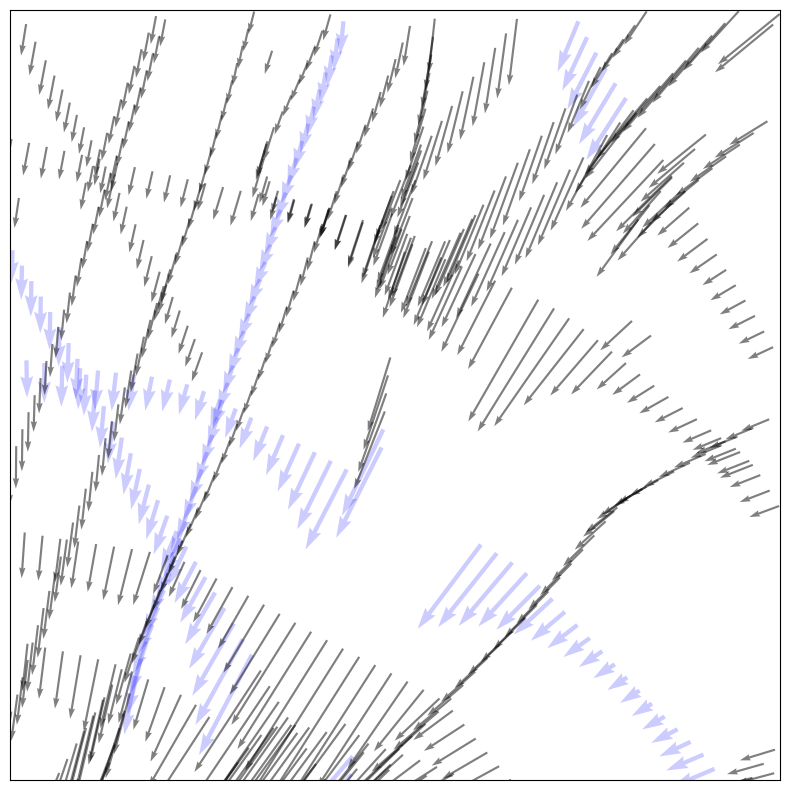

In [51]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(figsize = (10, 10))

ax.quiver(
    x_test[:, 0].detach().cpu().numpy(), 
    x_test[:, 1].detach().cpu().numpy(), 
    mean.detach().cpu().detach()[:, 0].numpy(), 
    mean.detach().cpu().detach()[:, 1].numpy(), 
    color = "blue", 
    alpha = 0.2,
    scale = 30
)

'''
ax.quiver(
    x_test[:, 0].detach().cpu().numpy(), 
    x_test[:, 1].detach().cpu().numpy(), 
    mean_pred_test.detach().cpu().detach()[:, 0].numpy(), 
    mean_pred_test.detach().cpu().detach()[:, 1].numpy(), 
    color = "blue", 
    alpha = 0.5,
    scale = 30
)
'''

ax.quiver(
    x_train[:, 0].detach().cpu().numpy(), 
    x_train[:, 1].detach().cpu().numpy(), 
    y_train.detach().cpu().detach()[:, 0].numpy(), 
    y_train.detach().cpu().detach()[:, 1].numpy(), 
    color = "black", 
    alpha = 0.5,
    scale = 30
)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
    
ax.set_aspect("equal")

In [ ]:
covar_pred_test.

torch.Size([230, 230])